# Setup

#### Imports

In [1]:
import os
import sys
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from scipy.stats import fisher_exact

import warnings

#### Notebook Configuration

In [2]:
warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

#### Constants

In [3]:
SEED = 42 # Random seed for reproducibility

# Split Ratios
TRAIN_SIZE = 0.8  # Proportion of data for training set
VAL_SIZE = 0.1  # Proportion of data for validation set
TEST_SIZE = 0.1  # Proportion of data for test set

# Columns
TARGET_COL = 'is_bad'  # Target column for classification
NUMERICAL_COLS = ["annual_inc","delinq_2yrs"]
CAT_COLS = ["home_ownership", "verification_status", "pymnt_plan", "purpose_cat", "zip_code", "addr_state", ]
# CONT_COLS = ["annual_inc", "debt_to_income", ""]
# TEXT_COLS = ["Notes", "purpose", ]
# RAT_COLS = ["delinq_2yrs"]
# DISCRETE_COLS = ["open_acc", "pub_rec", "total_acc", "acc_now_delinq", "tot_coll_amt", "tot_cur_bal", "total_rev_hi_lim"]
# DATE_COLS = ["earliest_cr_line"]

# Filepaths
DATA_PATH = 'lending_club_dataset.csv'
SCHEMA_VALIDATION_PATH = 'schema_validation_sheet.csv'
ERROR_DATASET_PATH = 'error_dataset.csv'

# Allowed column datatypes (These are the allowed pandas dtypes for the dataset)
ALLOWED_DTYPES = ['Int64', 'float64', 'object', 'datetime64[ns]']

# Helper Functions

#### Individual Column Description

In [4]:
# get individual column description
def describe_column(df: pd.DataFrame, col: str):
    print(f"Missing Values: {df[col].isnull().sum()}")
    print(f"Unique Values: {df[col].nunique()}")

    try:
        print(f"Min Value: {df[col].min()}")
        print(f"Max Value: {df[col].max()}")
    except:
        pass

    print(df[col].value_counts(dropna=False).head(10))
    print()
    print(df[col].describe(include='all'))
    print()
    print(df[col].dtype.name)

# Visualizations

In [65]:
def scatter_plot(df: pd.DataFrame, x_col: str, y_col: str, xlim: tuple = None, ylim: tuple = None, figsize=(8, 6)):
    # Scatter plot between two numerical columns
    plt.figure(figsize=figsize)
    plt.scatter(df[x_col], df[y_col], alpha=0.6, edgecolor='k')
    plt.title(f"Scatter Plot: {x_col} vs {y_col}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    # Limit the ranges of axes

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.show()

# Statistical Tests

#### Fisher's Exact Test

In [5]:
def fisher_exact_test(df: pd.DataFrame, feature_col: str, positive_feature: int, target_col: str):
    contingency_table = pd.crosstab(df[feature_col] == positive_feature, df[target_col])

    print("Contingency table:\n", contingency_table)

    # Fisher's exact test
    odds_ratio, p_value = fisher_exact(contingency_table)

    print(f"Fisher's Exact Test odds ratio: {odds_ratio:.4f}")
    print(f"p-value: {p_value:.4g}")

# Loading the Dataset, Schema Validation Sheet, and Error set

In [6]:
# Utility: safe read CSV with basic dtype hints
def read_csv_safely(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset not found at {path}. Please ensure the CSV is in the workspace root.")
    # Low-memory to reduce dtype inference churn
    return pd.read_csv(path, low_memory=False)

In [7]:
# Load dataset
try:
    df_raw = read_csv_safely(DATA_PATH)
    print("Loaded dataset with shape:", df_raw.shape)
except Exception as e:
    print("Failed to load dataset:", e)
    raise

Loaded dataset with shape: (10000, 28)


In [8]:
# Load validation schema
try:
    df_schema_validation = read_csv_safely(SCHEMA_VALIDATION_PATH)
    print("Loaded dataset with shape:", df_schema_validation.shape)
except Exception as e:
    print("Failed to load dataset:", e)
    raise

Loaded dataset with shape: (28, 9)


In [9]:
# Load error dataset
# try:
#     df_error = read_csv_safely(ERROR_DATASET_PATH)
#     print("Loaded dataset with shape:", df_error.shape)
# except Exception as e:
#     print("Failed to load dataset:", e)
#     raise

# Pre-split Data Validations and Transformations

#### Create dataframe df_clean

In [10]:
df_clean = df_raw.copy()

#### Check that all columns in dataset are present in schema validation

In [11]:
def check_cols_present(df: pd.DataFrame, df_schema: pd.DataFrame):
    
    schema_cols = df_schema['column'].tolist()

    cols_missing_from_schema = set(df.columns) - set(schema_cols)
    if cols_missing_from_schema:
        print(f"Columns not present in schema but in dataset: {list(cols_missing_from_schema)}")
    cols_missing_from_dataframe = set(schema_cols) - set(df.columns)
    if cols_missing_from_dataframe:
        print(f"Columns present in schema but not in dataset: {list(cols_missing_from_dataframe)}")

check_cols_present(df_clean, df_schema_validation)

#### Find problematic values when trying to convert column to target data type

In [12]:
def find_problematic_values_for_conversion(df: pd.DataFrame, df_schema_val: pd.DataFrame):
    df_col_checks = df.copy()
    cols_with_issues = {}

    for col in df_col_checks.columns:

        if df_col_checks[col].dtype.name != df_schema_val.loc[df_schema_val['column'] == col, 'expected_dtype'].values[0]:

            # for dtypes starting as object, int64, and float64 that will be converted to Int64
            if df_schema_val.loc[df_schema_val['column'] == col, 'expected_dtype'].values[0] == "Int64":        
                try:
                    # Attempt conversion directly to Int64
                    df_col_checks[col] = df_col_checks[col].astype("Int64")
                except Exception:
                    # Anything that can't be coerced into Int64 is problematic
                    bad_mask = pd.to_numeric(df_col_checks[col], errors="coerce").isna()
                    problematic = df_col_checks.loc[bad_mask, col].unique().tolist()
                    cols_with_issues[col] = problematic

            # for dtypes starting as object that will be converted to datetime
            if df_schema_val.loc[df_schema_val['column'] == col, 'expected_dtype'].values[0] == "datetime64[ns]":
                try:
                    # Attempt conversion directly to datetime
                    df_col_checks[col] = pd.to_datetime(df_col_checks[col], format="%m/%d/%y")
                except Exception:
                    # Anything that can't be coerced into datetime is problematic
                    bad_mask = pd.to_datetime(df_col_checks[col], format="%m/%d/%y", errors="coerce").isna()
                    problematic = df_col_checks.loc[bad_mask, col].unique().tolist()
                    cols_with_issues[col] = problematic

    for k,v in cols_with_issues.items():
        print(f"Column {k} has problematic values when attempting to convert: {v}")

find_problematic_values_for_conversion(df_clean, df_schema_validation)

Column emp_length has problematic values when attempting to convert: ['na']


#### Fixing specific columns with problematic values in df_raw

In [13]:
# Fixing "na" values in "emp_length"
df_clean["emp_length"] = df_clean["emp_length"].replace("na", pd.NA)

#### Convert columns to target data type in df_clean

Since problematic values have been fixed in df_clean, the following cell should run without errors

In [14]:
# Transform column types based on schema validation
for col in df_clean.columns:
    if df_clean[col].dtype.name != df_schema_validation.loc[df_schema_validation['column'] == col, 'expected_dtype'].values[0]:

        if df_schema_validation.loc[df_schema_validation['column'] == col, 'expected_dtype'].values[0] == "Int64":            
            df_clean[col] = df_clean[col].astype("Int64")

        if df_schema_validation.loc[df_schema_validation['column'] == col, 'expected_dtype'].values[0] == "datetime64[ns]":
            
            if col == "earliest_cr_line":
                df_clean[col] = pd.to_datetime(df_clean[col], format="%m/%d/%y")

#### Confirm that there are no columns that do match intended dtype

In [15]:
for col in df_clean.columns:
    if df_clean[col].dtype.name != df_schema_validation.loc[df_schema_validation['column'] == col, 'expected_dtype'].values[0]:
        print(col)

    if df_clean[col].dtype.name not in ALLOWED_DTYPES:
        print(f"Column {col} has unexpected dtype {df_clean[col].dtype.name}")

#### Check that values in each column are within ranges and allowed values prescribed in schema validation

In [16]:
def check_against_schema(df: pd.DataFrame, schema_df: pd.DataFrame):
    issues = []

    for _, row in schema_df.iterrows():
        col = row['column']
        unique_min = row['unique_min']
        unique_max = row['unique_max']
        min_allowed = row['min_allowed']
        max_allowed = row['max_allowed']
        allowed_values = row['allowed_values']
        
        if col in df.columns:            
            
            #unique min
            if unique_min != "na":
                unique_count = df[col].nunique()
                if unique_count < int(unique_min):
                    issues.append(f"{col} has a unique count {unique_count} less than minimum {unique_min}.")

            #unique max
            if unique_max != "na":
                unique_count = df[col].nunique()
                if unique_count > int(unique_max):
                    issues.append(f"{col} has a unique count {unique_count} greater than maximum {unique_max}.")

            #allowed numerical values``
            if df[col].dtype.name in ["Int64", "float64"]:
                if min_allowed != "na":
                    min_value = df[col].min()
                    unallowed = df[col][df[col] < int(min_allowed)]
                    if not unallowed.empty:
                        issues.append(f"{col} has {len(unallowed)} values {sorted(set(unallowed.tolist()))} less than {min_allowed}.")

                if max_allowed != "na":
                    max_value = df[col].max()
                    unallowed = df[col][df[col] > int(max_allowed)]
                    if not unallowed.empty:
                        issues.append(f"{col} has {len(unallowed)} values {sorted(set(unallowed.tolist()))} greater than {max_allowed}.")

            #allowed date values
            if df[col].dtype.name == "datetime64[ns]":
                if min_allowed != "na":
                    min_allowed = pd.to_datetime(min_allowed, format="%Y%m%d")
                    unallowed = df[col][df[col] < min_allowed]
                    if not unallowed.empty:
                        issues.append(f"{col} has {len(unallowed)} values {sorted(set(unallowed.tolist()))} less than {min_allowed}.")

                if max_allowed != "na":
                    max_allowed = pd.to_datetime(max_allowed, format="%Y%m%d")
                    unallowed = df[col][df[col] > max_allowed]                    
                    if not unallowed.empty:
                        issues.append(f"{col} has {len(unallowed)} values {sorted(set(unallowed.tolist()))} greater than {max_allowed}.")

            #allowed categorical values
            if allowed_values != "na" and df[col].dtype.name == "object":
                allowed_set = set(allowed_values.split(","))
                actual_set = set(df[col].dropna().unique())
                disallowed = list(actual_set - allowed_set)
                if disallowed:
                    issues.append(f"{col} has disallowed values: {disallowed}.")

    return issues

check_against_schema(df_clean, df_schema_validation)

['emp_length has a unique count 13 greater than maximum 10.',
 'emp_length has 8 values [11, 22, 33] greater than 10.',
 "earliest_cr_line has 26 values [Timestamp('2050-12-01 00:00:00'), Timestamp('2056-09-01 00:00:00'), Timestamp('2059-06-01 00:00:00'), Timestamp('2062-09-01 00:00:00'), Timestamp('2063-01-01 00:00:00'), Timestamp('2063-09-01 00:00:00'), Timestamp('2064-09-01 00:00:00'), Timestamp('2064-10-01 00:00:00'), Timestamp('2065-05-01 00:00:00'), Timestamp('2065-09-01 00:00:00'), Timestamp('2066-06-01 00:00:00'), Timestamp('2066-12-01 00:00:00'), Timestamp('2067-04-01 00:00:00'), Timestamp('2067-06-01 00:00:00'), Timestamp('2067-07-01 00:00:00'), Timestamp('2067-09-01 00:00:00'), Timestamp('2067-11-01 00:00:00'), Timestamp('2068-01-01 00:00:00'), Timestamp('2068-08-01 00:00:00'), Timestamp('2068-09-01 00:00:00'), Timestamp('2068-12-01 00:00:00')] greater than 2008-11-02 00:00:00.",
 'revol_util has 1 values [100.6] greater than 100.']

#### Fix columns with specific data range problems

##### fixing "emp_length"

In [17]:
rows_with_emp_length_issues = df_clean[df_clean["emp_length"].isin([11,22,33])]
print(f"Rows with emp_length issues: {len(rows_with_emp_length_issues)}")
print(f"Number of positive is_bad values in rows_with_emp_length_issues: {rows_with_emp_length_issues['is_bad'].sum()}")
print(f"Total number of positive is_bad values in full dataset: {df_clean['is_bad'].sum()}")
print(f"Percentage of rows_with_emp_length_issues against total positive values: {rows_with_emp_length_issues['is_bad'].sum() / df_clean['is_bad'].sum() * 100:.2f}%")

Rows with emp_length issues: 8
Number of positive is_bad values in rows_with_emp_length_issues: 8
Total number of positive is_bad values in full dataset: 1295
Percentage of rows_with_emp_length_issues against total positive values: 0.62%


All rows with error values in this emp_length have "is_bad" = 1. Dropping rows until cause of error can be confirmed.

In [18]:
# Drop rows with emp_length issues
print(df_clean.shape)
df_clean = df_clean[~df_clean["emp_length"].isin([11,22,33])]
print(df_clean.shape)

(10000, 28)
(9992, 28)


##### fixing "earliest_cr_line" and converting to years since earliest credit line

<Axes: >

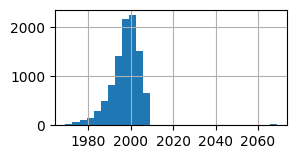

In [19]:
df_clean["earliest_cr_line"].hist(bins=30, figsize=(3, 1.5))

<Axes: >

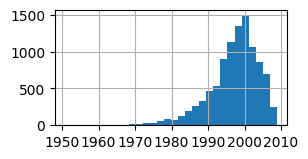

In [20]:
# any dates after cutoff date will have 100 years subtracted
dates = pd.to_datetime(df_clean["earliest_cr_line"], format="%m/%d/%y", errors="coerce")
cutoff = pd.Timestamp(df_schema_validation.loc[df_schema_validation['column'] == "earliest_cr_line", 'max_allowed'].values[0])
dates = dates.where(dates < cutoff, dates - pd.DateOffset(years=100))
df_clean["earliest_cr_line"] = dates
df_clean["earliest_cr_line"].hist(bins=30, figsize=(3, 1.5))

Converting earliest_cr_line to years since earliest credit line

In [21]:
# convert earliest_cr_line to years since earliest credit line based on max date in earliest_cr_line
max_date = df_clean['earliest_cr_line'].max()
df_clean['earliest_cr_line'] = (max_date - df_clean['earliest_cr_line']).dt.days // 365
df_clean['earliest_cr_line'] = df_clean['earliest_cr_line'].astype("Int64")

#### fixing "revol_util"

"revol_util" only has one out of range value from what's prescribed in schema validation which could likely be valid. Going to leave unchanged

#### fixing "home_ownership"
home_ownership has a single value of "NONE" that will be changed to "OTHER"

In [22]:
print(df_clean['home_ownership'].value_counts())

mapping = {
    "NONE": "OTHER"    
}
df_clean['home_ownership'] = df_clean['home_ownership'].replace(mapping)

print()
print(df_clean['home_ownership'].value_counts())

home_ownership
RENT        4741
MORTGAGE    4443
OWN          773
OTHER         34
NONE           1
Name: count, dtype: int64

home_ownership
RENT        4741
MORTGAGE    4443
OWN          773
OTHER         35
Name: count, dtype: int64


#### Pre-split EDA (no analyses involving features-to-labels)

In [23]:
def summarize_near_constant_features(
    df: pd.DataFrame,
    *,
    dominant_thresh: float = 0.98,   # flag if top value covers ≥ this fraction of non-null values
    max_unique_for_flag: int | None = None,  # optionally also require unique values ≤ this number
    min_non_null: int = 5,           # skip columns with too few non-nulls
    treat_bool_as_categorical: bool = True
) -> pd.DataFrame:
    """
    Analyze columns for 'near-constant' behavior and return a summary DataFrame.

    Columns are flagged when the dominant (most frequent) value's share among non-null values
    is ≥ dominant_thresh. Optionally (if max_unique_for_flag is set), we also require that the
    number of unique non-null values ≤ max_unique_for_flag.

    Parameters
    ----------
    df : pd.DataFrame
        Input data.
    dominant_thresh : float, default 0.98
        Threshold for dominant value proportion to flag near-constant.
    max_unique_for_flag : int or None, default None
        If set, near-constant flag additionally requires unique_count ≤ this.
        (E.g., set to 2 to flag only nearly-all-0/1 columns.)
    min_non_null : int, default 5
        Skip columns with fewer than this many non-null observations.
    treat_bool_as_categorical : bool, default True
        If True, boolean columns are summarized as categoricals.

    Returns
    -------
    pd.DataFrame
        Columns:
        - column
        - dtype
        - non_null_count
        - missing_rate
        - unique_count
        - dominant_value
        - dominant_count
        - dominant_share
        - minority_count
        - variance (numeric only; else NaN)
        - std (numeric only; else NaN)
        - min_value (numeric only; else NaN)
        - max_value (numeric only; else NaN)
        - entropy_bits (Shannon entropy base-2 on value distribution)
        - is_binary_like (unique_count == 2)
        - near_constant_flag (boolean)
        - top_5_values (string formatted "value:count; …")
    """
    summaries = []

    for col in df.columns:
        s = df[col]
        non_null = s.dropna()
        non_null_count = int(non_null.shape[0])
        missing_rate = (1.0 - (non_null_count / max(1, s.shape[0])))*100

        # Handle dtype classification early so branches can use it
        is_bool = pd.api.types.is_bool_dtype(s)
        is_numeric = pd.api.types.is_numeric_dtype(s) and not (is_bool and treat_bool_as_categorical)

        # Precompute min/max for numeric columns
        if is_numeric and non_null_count > 0:
            try:
                min_value = float(non_null.astype(float).min())
                max_value = float(non_null.astype(float).max())
            except Exception:
                # Fallback in case of mixed numeric types that fail astype(float)
                min_value = float(pd.to_numeric(non_null, errors='coerce').min())
                max_value = float(pd.to_numeric(non_null, errors='coerce').max())
        else:
            min_value = np.nan
            max_value = np.nan

        # # Top-5 most common values (include NaN label consistent with helper)
        # try:
        #     top5_vals = top5_summary(s)
        # except Exception:
        #     # If helper not available for any reason, compute a simple fallback
        vc_tmp = s.value_counts(dropna=False).head(5)
        def _fmt(v):
            if pd.isna(v):
                return 'NaN'
            txt = str(v)
            return (txt[:60] + '…') if len(txt) > 60 else txt
        top5_vals = "; ".join([f"{_fmt(idx)}:{int(cnt)}" for idx, cnt in vc_tmp.items()])

        if non_null_count < min_non_null:
            # Not enough data to assess; still record info
            summaries.append({
                "column": col,
                "dtype": s.dtype.name,
                "non_null_count": non_null_count,
                "missing_rate%": missing_rate,
                "unique_count": non_null.nunique(dropna=True),
                "min_value": min_value,
                "max_value": max_value,
                "dominant_value": np.nan,
                "dominant_count": 0,
                "dominant_share": np.nan,
                "minority_count": 0,
                "variance": np.nan,
                "std": np.nan,
                "entropy_bits": np.nan,
                "is_binary_like": False,
                "near_constant_flag": False,
                "top_5_values": top5_vals,
            })
            continue

        # Value counts for frequencies
        vc = non_null.value_counts(dropna=False)
        dominant_value = vc.index[0]
        dominant_count = int(vc.iloc[0])
        unique_count = int(vc.shape[0])
        dominant_share = dominant_count / non_null_count
        minority_count = non_null_count - dominant_count

        # Entropy (base-2)
        probs = (vc / non_null_count).to_numpy()
        entropy_bits = float(-np.sum(probs * np.log2(probs))) if unique_count > 1 else 0.0

        # Numeric variance/std if applicable
        if is_numeric:
            variance = float(non_null.astype(float).var(ddof=1)) if non_null_count > 1 else 0.0
            std = float(np.sqrt(variance))
        else:
            variance = np.nan
            std = np.nan

        # Binary-like flag
        is_binary_like = (unique_count == 2)

        # Near-constant logic
        meets_share = dominant_share >= dominant_thresh
        meets_unique = True if max_unique_for_flag is None else (unique_count <= max_unique_for_flag)
        near_constant_flag = bool(meets_share and meets_unique)

        summaries.append({
            "column": col,
            "dtype": s.dtype.name,
            "non_null_count": non_null_count,
            "missing_rate%": missing_rate,
            "unique_count": unique_count,
            "min_value": min_value,
            "max_value": max_value,
            "dominant_value": dominant_value,
            "dominant_count": dominant_count,
            "dominant_share": dominant_share,
            "minority_count": minority_count,
            "variance": variance,
            "std": std,
            "entropy_bits": entropy_bits,
            "is_binary_like": is_binary_like,
            "near_constant_flag": near_constant_flag,
            "top_5_values": top5_vals,
        })

    out = pd.DataFrame(summaries)
    # Order: flags first, then by dominant_share desc, then low entropy
    # out = out.sort_values(
    #     by=["near_constant_flag", "dominant_share", "entropy_bits"],
    #     ascending=[False, False, True],
    #     kind="mergesort"
    # ).reset_index(drop=True)
    return out

In [24]:
# Recompute summary with new columns
df_summary = summarize_near_constant_features(df_clean)
df_summary[["column","dtype","missing_rate%","unique_count","min_value","max_value","dominant_value","dominant_share","variance","near_constant_flag","top_5_values"]]

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
0,Id,Int64,0.000000,9992,1.0,10000.00,1,0.000100,8.328317e+06,False,1:1; 6673:1; 6666:1; 6667:1; 6668:1
1,is_bad,Int64,0.000000,2,0.0,1.00,0,0.871197,1.122241e-01,False,0:8705; 1:1287
2,emp_title,object,5.924740,8175,NaN,NaN,US Army,0.003936,NaN,False,NaN:592; US Army:37; Bank of America:23; IBM:2...
3,emp_length,Int64,2.502002,10,1.0,10.00,10,0.221720,1.165920e+01,False,10:2160; 1:2083; 2:1183; 3:1010; 4:889
4,home_ownership,object,0.000000,4,NaN,NaN,RENT,0.474480,NaN,False,RENT:4741; MORTGAGE:4443; OWN:773; OTHER:35
5,annual_inc,float64,0.010008,1898,2000.0,900000.00,60000.0,0.038134,2.362215e+09,False,60000.0:381; 50000.0:267; 40000.0:222; 75000.0...
6,verification_status,object,0.000000,3,NaN,NaN,not verified,0.436749,NaN,False,not verified:4364; VERIFIED - income:3213; VER...
7,pymnt_plan,object,0.000000,2,NaN,NaN,n,0.999800,NaN,True,n:9990; y:2
8,Notes,object,32.295837,6756,NaN,NaN,Personal Loan,0.000443,NaN,False,NaN:3227; Personal Loan:3; Debt Consolidation:...
9,purpose_cat,object,0.000000,27,NaN,NaN,debt consolidation,0.445757,NaN,False,debt consolidation:4454; credit card:1273; oth...


#### "pymnt_plan" has 99.98% dominant values and no useful information; it will be dropped pre-split

In [25]:
print(df_clean.shape)
df_clean.drop(columns=["pymnt_plan"], inplace=True)
print(df_clean.shape)

(9992, 28)
(9992, 27)


#### collections_12_mths_ex_med

In [26]:
# # # collections_12_mths_ex_med consists of 0s and missing values; will convert missing values to -1 and examine further after post-split
print(df_clean["collections_12_mths_ex_med"].value_counts())
print(df_clean["collections_12_mths_ex_med"].isna().sum())

collections_12_mths_ex_med
0    9960
Name: count, dtype: Int64
32


Type of missingness for "collections_12_mths_ex_med" is unknown at this time.

# Pre-split EDA

In [27]:
df_summary

,column,dtype,non_null_count,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_count,dominant_share,minority_count,variance,std,entropy_bits,is_binary_like,near_constant_flag,top_5_values
0,Id,Int64,9992,0.000000,9992,1.0,10000.00,1,1,0.000100,9991,8.328317e+06,2885.882446,13.286558,False,False,1:1; 6673:1; 6666:1; 6667:1; 6668:1
1,is_bad,Int64,9992,0.000000,2,0.0,1.00,0,8705,0.871197,1287,1.122241e-01,0.334999,0.554146,True,False,0:8705; 1:1287
2,emp_title,object,9400,5.924740,8175,NaN,NaN,US Army,37,0.003936,9363,NaN,NaN,12.811292,False,False,NaN:592; US Army:37; Bank of America:23; IBM:2...
3,emp_length,Int64,9742,2.502002,10,1.0,10.00,10,2160,0.221720,7582,1.165920e+01,3.414557,3.037002,False,False,10:2160; 1:2083; 2:1183; 3:1010; 4:889
4,home_ownership,object,9992,0.000000,4,NaN,NaN,RENT,4741,0.474480,5251,NaN,NaN,1.344462,False,False,RENT:4741; MORTGAGE:4443; OWN:773; OTHER:35
5,annual_inc,float64,9991,0.010008,1898,2000.0,900000.00,60000.0,381,0.038134,9610,2.362215e+09,48602.625360,8.421853,False,False,60000.0:381; 50000.0:267; 40000.0:222; 75000.0...
6,verification_status,object,9992,0.000000,3,NaN,NaN,not verified,4364,0.436749,5628,NaN,NaN,1.543480,False,False,not verified:4364; VERIFIED - income:3213; VER...
7,pymnt_plan,object,9992,0.000000,2,NaN,NaN,n,9990,0.999800,2,NaN,NaN,0.002748,True,True,n:9990; y:2
8,Notes,object,6765,32.295837,6756,NaN,NaN,Personal Loan,3,0.000443,6762,NaN,NaN,12.720990,False,False,NaN:3227; Personal Loan:3; Debt Consolidation:...
9,purpose_cat,object,9992,0.000000,27,NaN,NaN,debt consolidation,4454,0.445757,5538,NaN,NaN,2.826104,False,False,debt consolidation:4454; credit card:1273; oth...


In [28]:
df_schema_validation

,column,expected_dtype,data_type,numerical_data,unique_min,unique_max,min_allowed,max_allowed,allowed_values
0,Id,Int64,Discrete,1,na,na,0,na,na
1,is_bad,Int64,Nominal,1,2,2,0,1,na
2,emp_title,object,Text,0,na,na,na,na,na
3,emp_length,Int64,Ordinal,1,1,10,1,10,na
4,home_ownership,object,Nominal,0,1,5,na,na,na
5,annual_inc,float64,Discrete,1,1,na,0,1000000,na
6,verification_status,object,Nominal,0,1,3,na,na,na
7,pymnt_plan,object,Nominal,0,1,2,na,na,na
8,Notes,object,Text,0,na,na,na,na,na
9,purpose_cat,object,Nominal,0,na,na,na,na,na


In [29]:
cols_num = df_schema_validation[df_schema_validation["data_type"].isin(["Discrete","Ratio"])]["column"].to_list()
cols_num

#show histograms for columns in cols_num from df_cleaned


['Id',
 'annual_inc',
 'debt_to_income',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'revol_bal',
 'revol_util',
 'total_acc']

#### Create new columns for financials

In [30]:
df_clean["debt_from_d2i_and_annual_inc"] = df_clean["debt_to_income"]/100 * df_clean["annual_inc"]
df_clean["debt_from_revols"] = df_clean["revol_bal"] * df_clean["revol_util"]/100

cols_num.append("debt_from_d2i_and_annual_inc")
cols_num.append("debt_from_revols")

describe_column(df_clean, "debt_from_revols")

Missing Values: 26
Unique Values: 9644
Min Value: 0.0
Max Value: 676121.04
debt_from_revols
0.0         274
<NA>         26
2.422         4
428.738       3
460.8         3
5430.6        2
1494.366      2
0.025         2
6660.444      2
318.444       2
Name: count, dtype: Int64

count         9966.0
mean     8361.026559
std      16530.13883
min              0.0
25%       1086.92425
50%         4122.367
75%       10107.4385
max        676121.04
Name: debt_from_revols, dtype: Float64

Float64


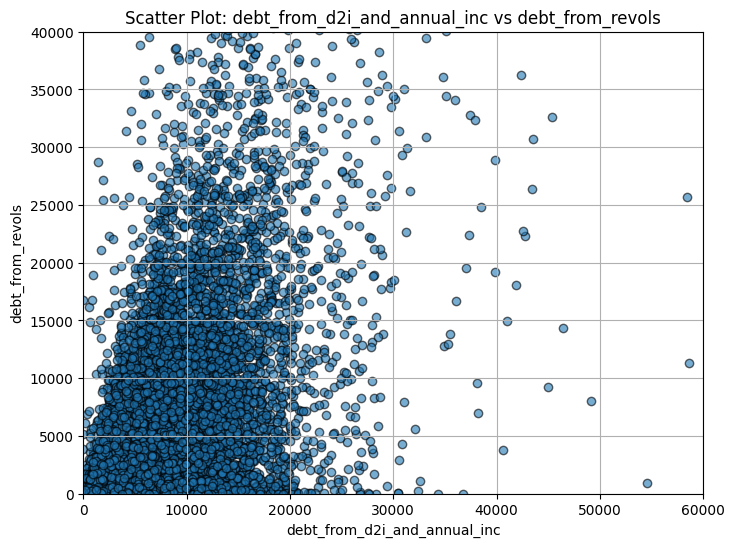

In [76]:
x_col = "debt_from_d2i_and_annual_inc"
y_col = "debt_from_revols"
scatter_plot(df_clean, "debt_from_d2i_and_annual_inc", "debt_from_revols", xlim=(0,60000), ylim=(0,40000))
# plt.figure(figsize=(8, 6))
# plt.scatter(df_clean[x_col], df_clean[y_col], alpha=0.6, edgecolor='k')
# plt.title(f"Scatter Plot: {x_col} vs {y_col}")
# plt.xlabel(x_col)
# plt.ylabel(y_col)
# plt.grid(True)
# # Limit the ranges of axes
# plt.show()

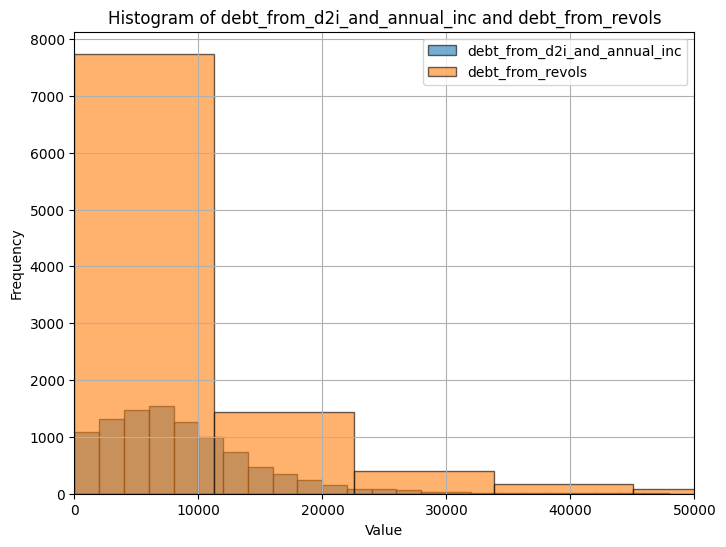

In [32]:
# Replace with the two columns you want to compare
col1 = "debt_from_d2i_and_annual_inc"
col2 = "debt_from_revols"

plt.figure(figsize=(8, 6))

plt.hist(df_clean[col1], bins=60, alpha=0.6, label=col1, edgecolor='black')
plt.hist(df_clean[col2], bins=60, alpha=0.6, label=col2, edgecolor='black')

plt.xlim(0, 50000) 

plt.title(f"Histogram of {col1} and {col2}")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
len(cols_num)

13

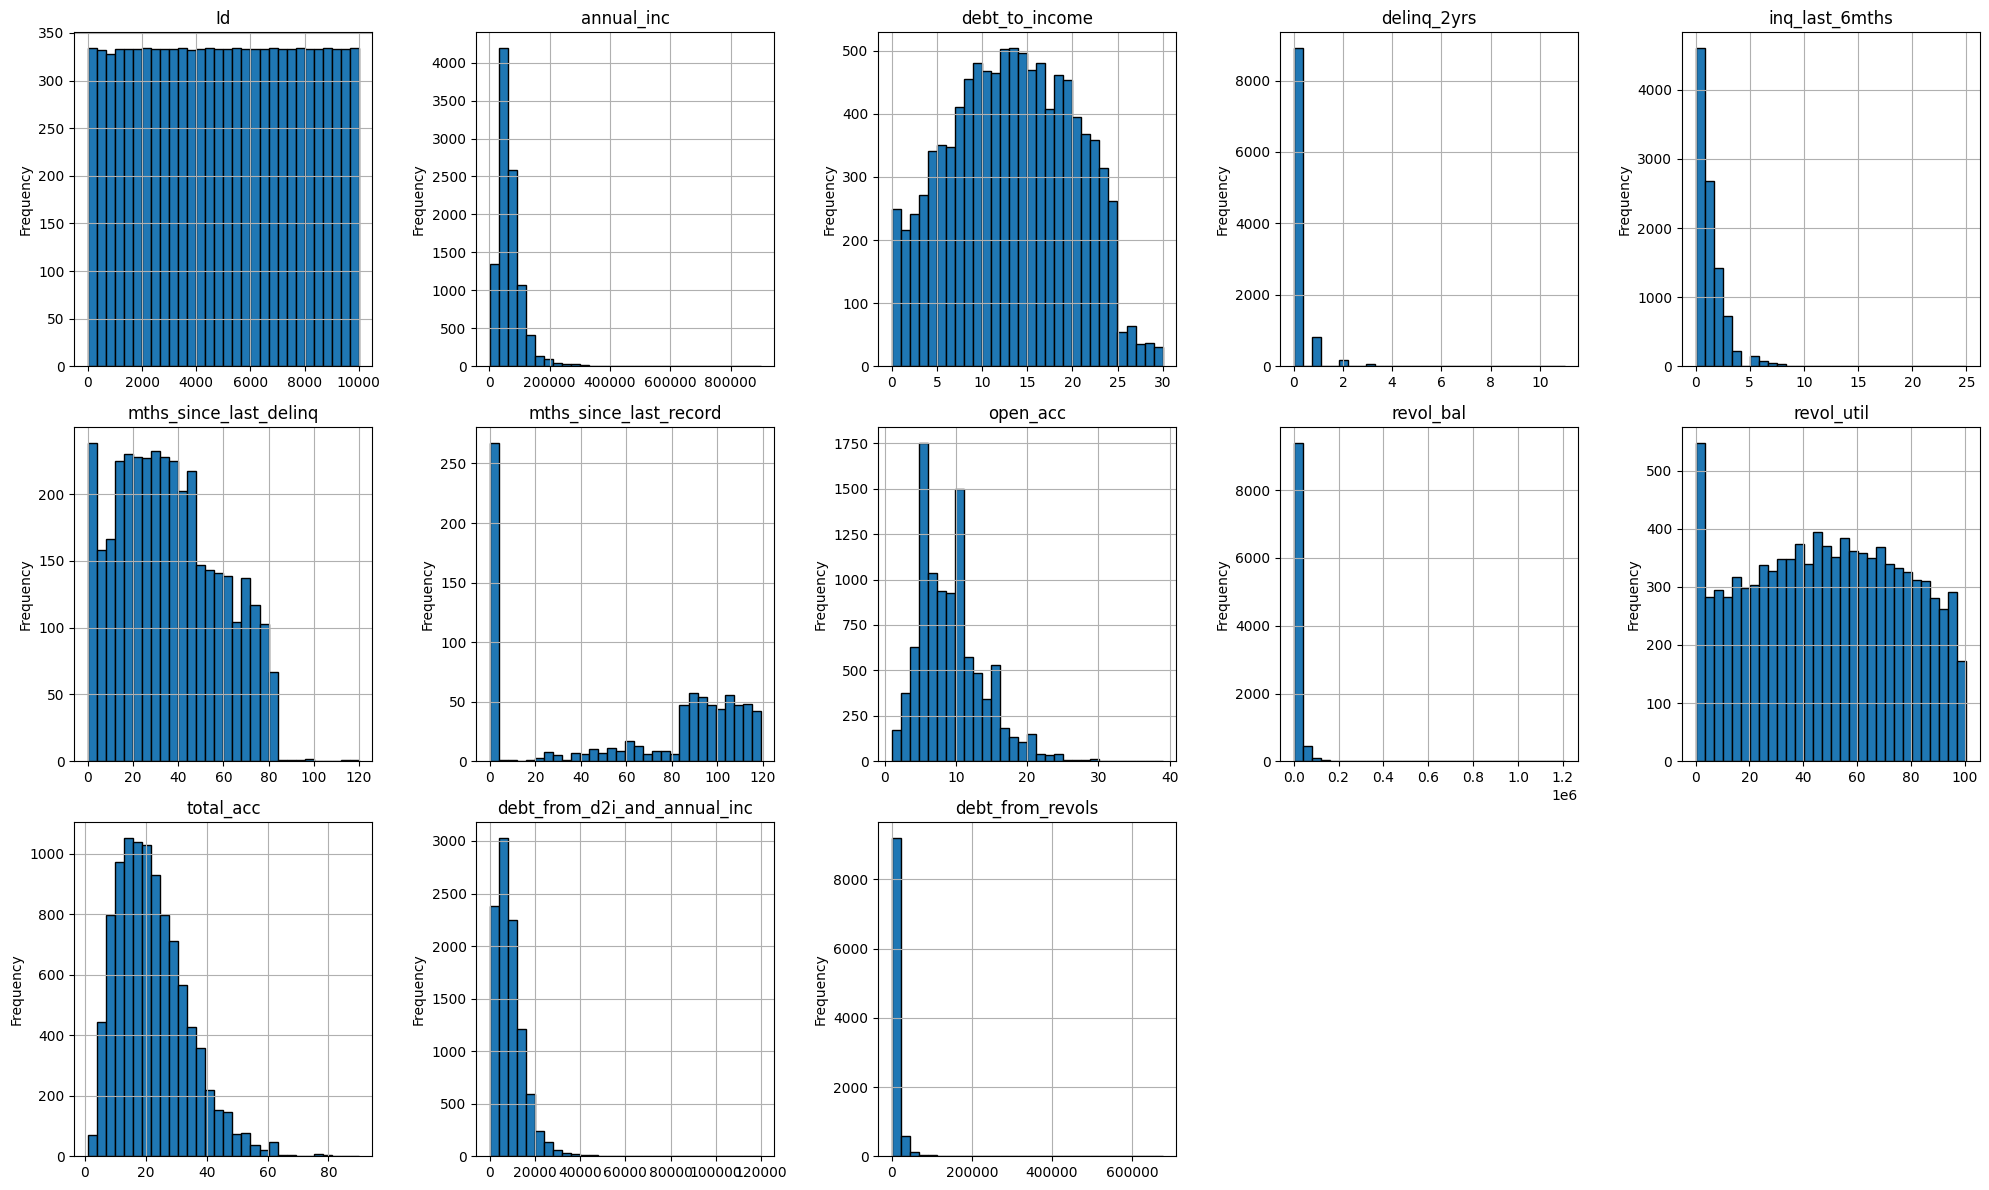

In [36]:
# Set up the grid: 3 rows × 4 columns
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Plot histograms for each column
for i, col in enumerate(cols_num):
    df_clean[col].hist(ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel('')

# Remove unused subplots if < 12 columns
for j in range(len(cols_num), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

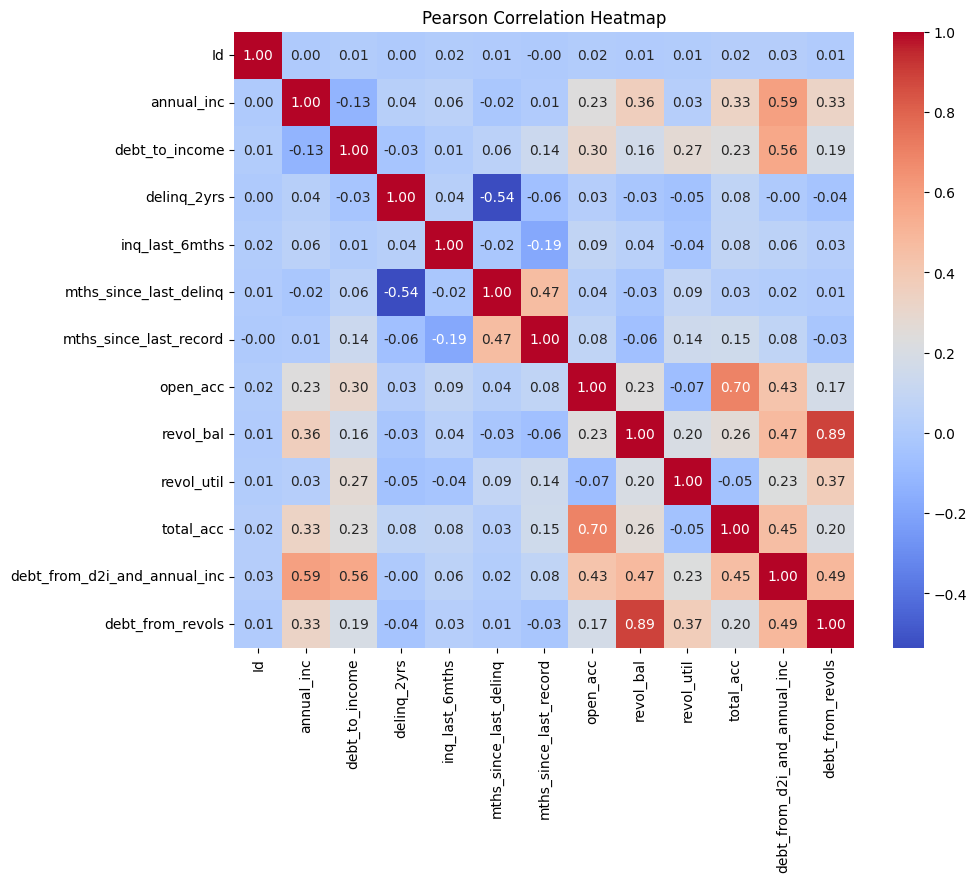

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[cols_num].corr(method="pearson"), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Heatmap")
plt.show()

In [73]:
# Compute correlation matrix
corr_matrix = df_clean[cols_num].corr(method="pearson")

# Select upper triangle of correlation matrix (to avoid duplicates)
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find pairs with correlation > 0.4 or < -0.4
threshold = 0.3
strong_pairs = (
    upper_tri.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature1", "level_1": "Feature2", 0: "Correlation"})
)

strong_pairs = strong_pairs[
    (strong_pairs["Correlation"].abs() > threshold)
].sort_values(by="Correlation", ascending=False)

strong_pairs = strong_pairs[strong_pairs["Feature1"] != strong_pairs["Feature2"]]
strong_pairs = strong_pairs[~((strong_pairs["Feature1"] == "revol_bal")& (strong_pairs["Feature2"] == "debt_from_revols"))]
strong_pairs = strong_pairs[~((strong_pairs["Feature1"] == "annual_inc")& (strong_pairs["Feature2"] == "debt_from_d2i_and_annual_inc"))]
strong_pairs = strong_pairs[~((strong_pairs["Feature1"] == "debt_from_d2i_and_annual_inc")& (strong_pairs["Feature2"] == "debt_from_revols"))]
strong_pairs = strong_pairs[~((strong_pairs["Feature1"] == "debt_to_income")& (strong_pairs["Feature2"] == "debt_from_d2i_and_annual_inc"))]
strong_pairs = strong_pairs[~((strong_pairs["Feature1"] == "revol_util")& (strong_pairs["Feature2"] == "debt_from_revols"))]

print(strong_pairs)

                  Feature1                      Feature2  Correlation
65                open_acc                     total_acc     0.695341
70               revol_bal  debt_from_d2i_and_annual_inc     0.473496
50  mths_since_last_delinq        mths_since_last_record     0.465476
75               total_acc  debt_from_d2i_and_annual_inc     0.454371
66                open_acc  debt_from_d2i_and_annual_inc     0.428138
18              annual_inc                     revol_bal     0.359756
20              annual_inc                     total_acc     0.329061
22              annual_inc              debt_from_revols     0.325069
27          debt_to_income                      open_acc     0.300972
34             delinq_2yrs        mths_since_last_delinq    -0.535391


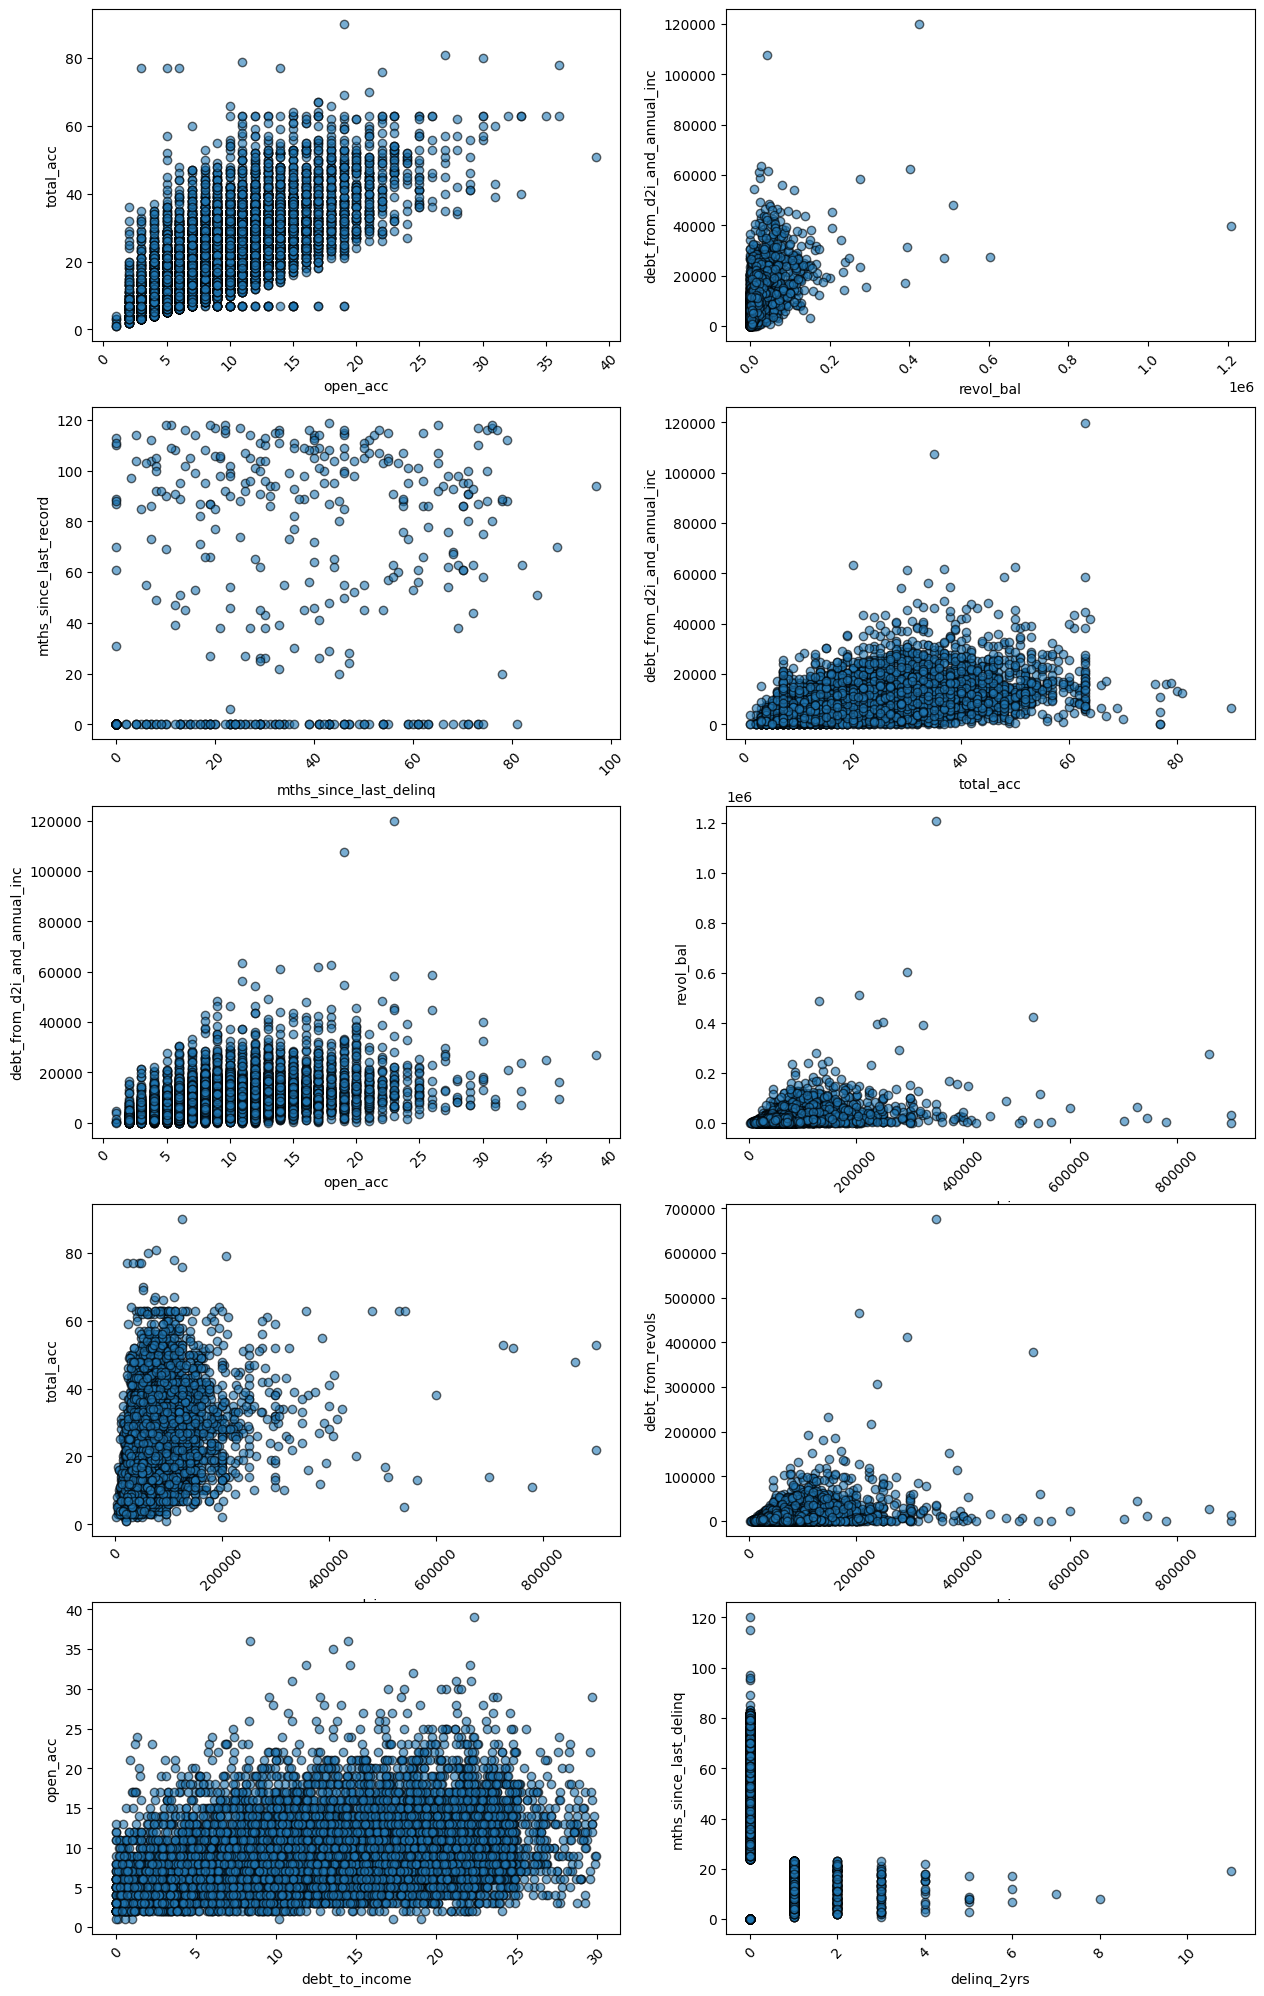

<Figure size 200x500 with 0 Axes>

<Figure size 200x500 with 0 Axes>

<Figure size 200x500 with 0 Axes>

<Figure size 200x500 with 0 Axes>

<Figure size 200x500 with 0 Axes>

<Figure size 200x500 with 0 Axes>

<Figure size 200x500 with 0 Axes>

<Figure size 200x500 with 0 Axes>

<Figure size 200x500 with 0 Axes>

<Figure size 200x500 with 0 Axes>

In [98]:
# # Set up the grid: 3 rows × 4 columns
# fig, axes = plt.subplots(3, 5, figsize=(20, 12))  
# axes = axes.flatten()  # Flatten to 1D array for easy iteration

# # Plot histograms for each column
# for i, col in enumerate(cols_num):
#     df_clean[col].hist(ax=axes[i], bins=30, edgecolor='black')
#     axes[i].set_title(col)
#     axes[i].set_ylabel('Frequency')
#     axes[i].set_xlabel('')

# # Remove unused subplots if < 12 columns
# for j in range(len(cols_num), len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()


strong_pairs.reset_index(drop=True, inplace=True)

# Create subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 25))  # 2 rows, 5 columns
axes = axes.flatten()

# Loop through rows and plot
for idx, row in strong_pairs.iterrows():
    feature1 = row["Feature1"]
    feature2 = row["Feature2"]

    plt.figure(figsize=(2,5))
    
    # plt.title()
    # plt.xlabel(x_col)
    # plt.ylabel(y_col)
    # plt.grid(True)

    axes[idx].scatter(df_clean[feature1], df_clean[feature2], alpha=0.6, edgecolor='k')  # x = column names, y = values
    # axes[idx].set_title(f"Scatter Plot: {feature1} vs {feature2}")
    axes[idx].set_xlabel(feature1)
    axes[idx].set_ylabel(feature2)
    # plt.grid(True)
    axes[idx].tick_params(axis='x', rotation=45)

# plt.tight_layout()
plt.show()

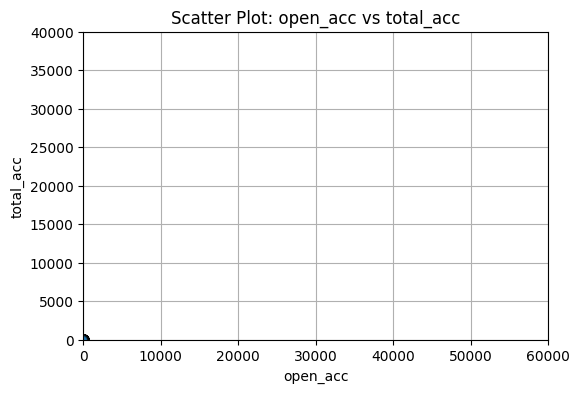

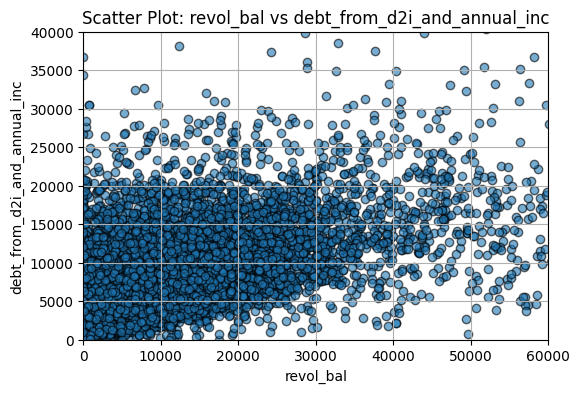

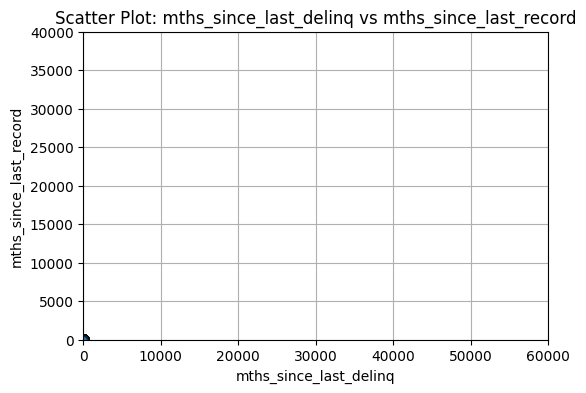

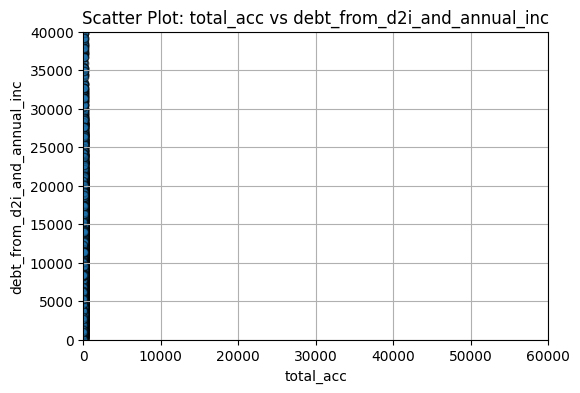

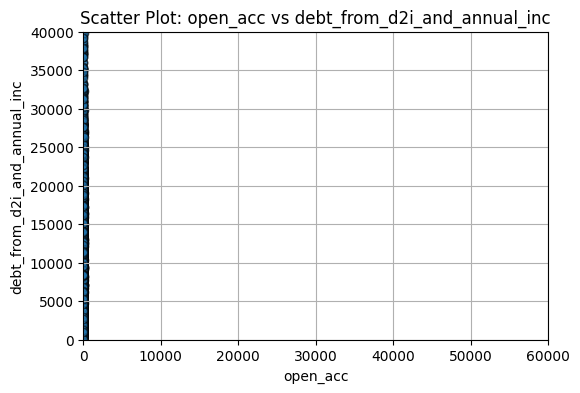

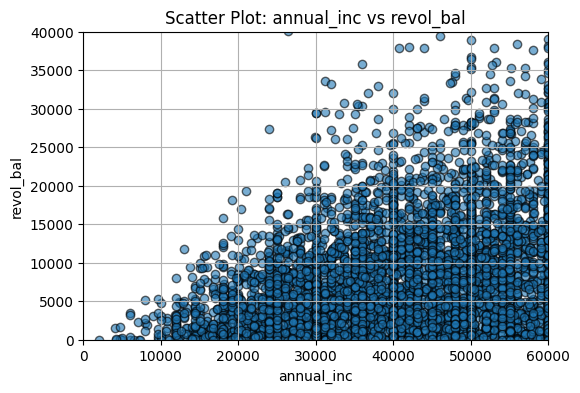

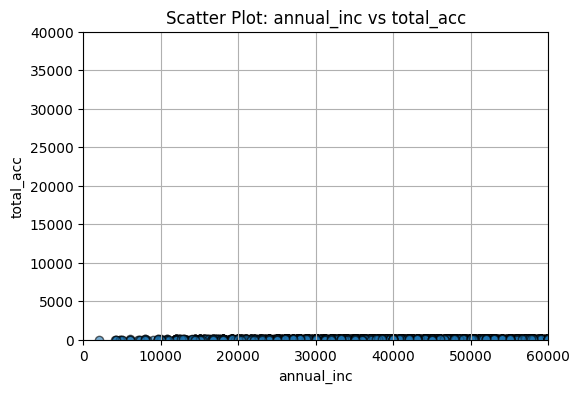

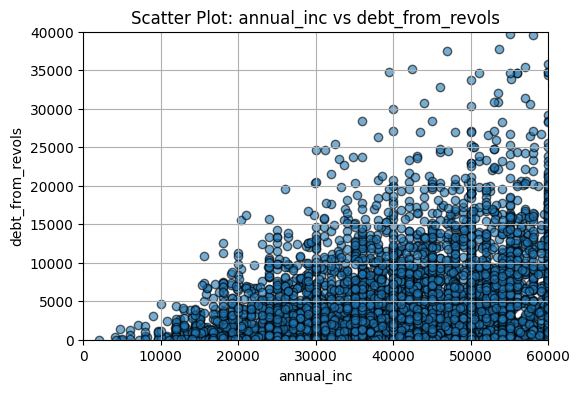

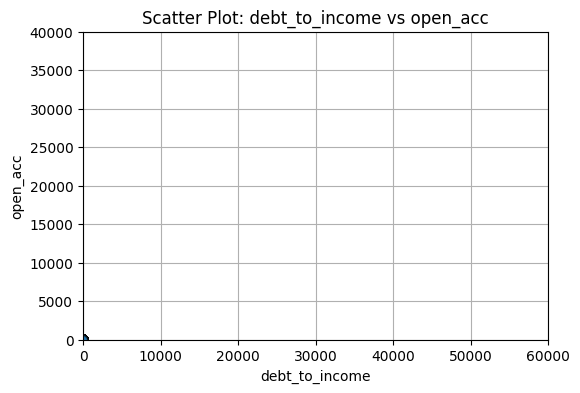

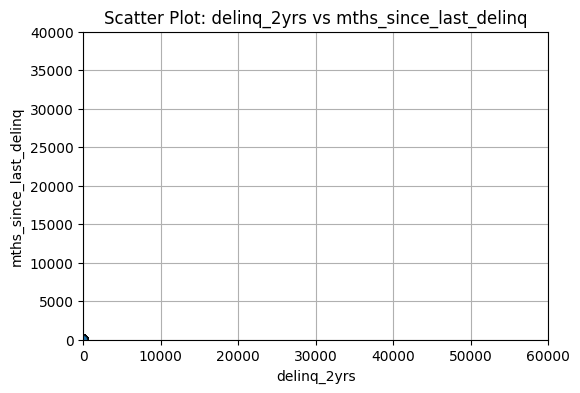

In [ ]:
# for _, row in strong_pairs.iterrows():
#     scatter_plot(df_clean, row["Feature1"], row["Feature2"], xlim=(0, 60000), ylim=(0, 40000), figsize=(6, 4))

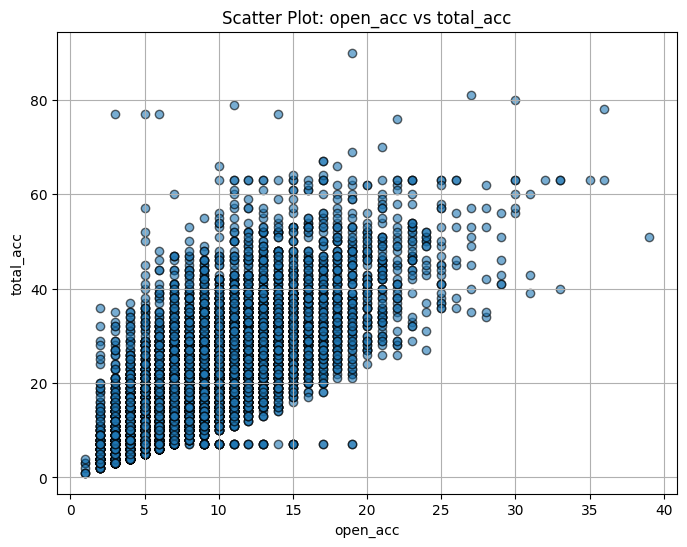

In [68]:
scatter_plot(df_clean, "open_acc", "total_acc")

# Splitting the dataset

In [ ]:
target_col = 'is_bad'
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

# First: split off the test set (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.10,
    stratify=y,
    random_state=42
)

# Next: split the remaining 90% into train (80%) and validation (10%)
# Since test already took 10%, we want 10/90 = ~0.1111 of the remainder as validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=1/9,   # ≈ 0.1111
    stratify=y_temp,
    random_state=42
)

splits = [X_train, X_val, X_test, y_train, y_val, y_test]    

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

# Check stratification worked (class balance preserved)
print("\nClass distribution in train:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in validation:")
print(y_val.value_counts(normalize=True))

print("\nClass distribution in test:")
print(y_test.value_counts(normalize=True))

# Works on PowerBI

In [ ]:
df_pbi = df_clean.copy()
drop_cols = ["Notes", "purpose","zip_code","mths_since_last_major_derog","policy_code"]
df_pbi.drop(columns=drop_cols, inplace=True)
df_pbi.to_csv("lending_club_dataset_for_powerbi.csv", index=False)

In [ ]:
df_pbi = df_clean.copy()

drop_cols = ["Notes", "purpose","zip_code","mths_since_last_major_derog"]
df_pbi.drop(columns=drop_cols, inplace=True)

mapping = {"RENT": "R", "MORTGAGE": "M", "OWN": "O", "OTHER": "X"}
df_pbi["home_ownership"] = df_pbi["home_ownership"].map(mapping)

mapping = {"Not Verified": "no", "Source Verified": "source", "Verified": "yes"}
df_pbi["verification_status"] = df_pbi["verification_status"].map(mapping)

mapping = {"PC1": "1","PC2": "2","PC3": "3","PC4": "4","PC5": "5"}
df_pbi["policy_code"] = df_pbi["policy_code"].map(mapping)
df_pbi["policy_code"] = df_pbi["policy_code"].astype("Int64")

df_pbi.to_csv("lending_club_dataset_for_powerbi.csv", index=False)

In [ ]:
df_pbi = df_clean.copy()

drop_cols = ["Notes", "emp_title", "purpose_cat", "purpose"]
df_pbi.drop(columns=drop_cols, inplace=True)

mapping = {"RENT": "R", "MORTGAGE": "M", "OWN": "O", "OTHER": "X"}
df_pbi["home_ownership"] = df_pbi["home_ownership"].map(mapping)

mapping = {"Not Verified": "no", "Source Verified": "source", "Verified": "yes"}
df_pbi["verification_status"] = df_pbi["verification_status"].map(mapping)

mapping = {"PC1": "1","PC2": "2","PC3": "3","PC4": "4","PC5": "5"}
df_pbi["policy_code"] = df_pbi["policy_code"].map(mapping)
df_pbi["policy_code"] = df_pbi["policy_code"].astype("Int64")

df_pbi.to_csv("lending_club_dataset_for_powerbi.csv", index=False)


can_work = ["zip_code","mths_since_last_major_derog","policy_code"]
confirmed_bad = ["Notes","purpose"]

#### Create dataset for PowerBI

In [ ]:
df_pbi = df_clean.copy()

drop_cols = ["Notes", "emp_title", "purpose_cat", "purpose"]
df_pbi.drop(columns=drop_cols, inplace=True)

mapping = {"RENT": "R", "MORTGAGE": "M", "OWN": "O", "OTHER": "X"}
df_pbi["home_ownership"] = df_pbi["home_ownership"].map(mapping)

mapping = {"Not Verified": "no", "Source Verified": "source", "Verified": "yes"}
df_pbi["verification_status"] = df_pbi["verification_status"].map(mapping)

mapping = {"PC1": "1","PC2": "2","PC3": "3","PC4": "4","PC5": "5"}
df_pbi["policy_code"] = df_pbi["policy_code"].map(mapping)
df_pbi["policy_code"] = df_pbi["policy_code"].astype("Int64")

df_pbi.to_csv("lending_club_dataset_for_powerbi.csv", index=False)


can_work = ["zip_code","mths_since_last_major_derog","policy_code"]
confirmed_bad = ["Notes","purpose"]

### Encode all nominal and ordinal values in object columns

In [ ]:
###################################
###################################
###################################
###################################
###################################
###################################

# for col in df_raw.select_dtypes(include=['object']).columns:
#     data_type = df_schema_validation.loc[df_schema_validation['column'] == col, 'data_typex'].values[0]
#     if data_type in ['Nominal', 'Ordinal']:        
#         le = LabelEncoder()
#         df_raw[col] = df_raw[col].astype(str)  # Ensure all values are strings
#         df_raw[col] = le.fit_transform(df_raw[col])

# Post-split EDA

In [ ]:
df_analysis = df_clean[df_clean['Id'].isin(X_train['Id'])]

In [ ]:
df_analysis.shape

In [ ]:
# df_analysis.to_csv("train_split.csv", index=False, encoding='utf-8')
missing = []
no_missing = []
for col in df_analysis.columns:
    if df_analysis[col].isnull().any():
        missing.append(col)
    else:
        no_missing.append(col)

## collections_12_mths_ex_med

In [ ]:
# collections_12_mths_ex_med has 29 missing values and by itself contains little information for prediction; confirming with Fisher's exact test
df_analysis["collections_12_mths_ex_med"] = df_analysis["collections_12_mths_ex_med"].fillna(-1)
df_analysis["collections_12_mths_ex_med"].value_counts()
fisher_exact_test(df_analysis, 'collections_12_mths_ex_med', -1, TARGET_COL)

In [ ]:
drop_cols.append('collections_12_mths_ex_med')

## initial_list_status

In [ ]:
# initial_list_status
col = 'initial_list_status'
print(f"Missing values in {col}: {df_analysis[col].isna().sum()}")
print(df_analysis[col].value_counts())

fisher_exact_test(df_analysis, col, 1, TARGET_COL)

In [ ]:
drop_cols.append('initial_list_status')

# Post-Split Transformations

In [ ]:
drop_cols

In [ ]:
# Add KeyError exception handling
for col in drop_cols:
    if col not in X_train.columns:
        print(f"Warning: Column '{col}' not found in X_train")
    if col not in X_val.columns:
        print(f"Warning: Column '{col}' not found in X_val")
    if col not in X_test.columns:
        print(f"Warning: Column '{col}' not found in X_test")
    try:
        X_train.drop(columns=[col], inplace=True)
        X_val.drop(columns=[col], inplace=True)
        X_test.drop(columns=[col], inplace=True)
    except KeyError as e:
        print(f"KeyError: {e} - One or more columns not found in DataFrame")

In [ ]:
X_train.head(5)